In [7]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Generate Double Moon Data
## Usage: data = dbmoon(N, d, r, w)
</br> The data set contains two regions A and B representing 2 classes
</br> each region is a half ring with radius r = 10, width = 6, one is upper half and the other is lower half
</br></br> d: distance between the two regions
</br> will generate region A centered at (0, 0) and region B is a mirror image of region A (w.r.t.x axis) with a (r, d) shift of origin
</br></br> N:  # of samples each class, default = 1000
</br> d: seperation of two class, negative value means overlapping (default=1)
</br> r: radius (default=10), w: width of ring (default=6)

In [3]:
def dbmoon(N=1000, d=1, r=10, w=6):
    # generate region A:
    # first generate a uniformly random distributed data points from (-r-w / 2, 0)
    # to (r+w / 2, r+w / 2) 
    N1 = 10 * N  # generate more points and select those meet criteria
    w2 = w / 2
    done = 0
    tmp1 = np.array([[]])
    while not done:
        tmp = np.array(2 * (r + w2) * (np.random.uniform(0, 1, (N1, 1)) - 0.5))
        tmp = np.column_stack((tmp, (r + w2) * np.random.uniform(0, 1, (N1, 1))))
        # 3rd column of tmp is the magnitude of each data point
        thirdCol = np.sqrt(np.multiply(tmp[:, 0], tmp[:, 0]) + np.multiply(tmp[:, 1], tmp[:, 1]))
        tmp = np.column_stack((tmp, thirdCol.T))
        idx = np.nonzero(np.logical_and((tmp[:, 2] > (r - w2)), (tmp[:, 2] < (r + w2))))
        if tmp1.shape == (1,0):
            tmp1 = tmp[:, 0:2][idx]
        else:
            tmp1 = np.row_stack((tmp1, tmp[:, 0:2][idx]))
        if len(idx[0]) >= N:
            done = 1
            # if not enough data point, generate more and test

    # region A data and class label 0
    # region B data is region A data flip y coordinate - d, and x coordinate +r
    data = np.column_stack((tmp1[0:N, :], np.zeros((N, 1))))
    data1 = np.column_stack(((tmp1[0:N, 0] + r), (-tmp1[0:N, 1] - d), np.ones((N, 1))))
    data = np.row_stack((data, data1))
    return data

# Plot the double moon data

In [107]:
def plot(data, target, mu):
    idx = np.nonzero(target)
    plt.plot(data[idx, 0], data[idx, 1], 'b.')
    idx = np.where(target == 0)
    plt.plot(data[idx, 0], data[idx, 1], 'r.')
    plt.plot(mu[:, 0], mu[:, 1], 'gs')
    plt.show()

# Initialize Clusters Centers using K-Means method

In [114]:
def k_means(data, k, threshold):
    indices = random.sample(range(len(data)), k)
    mu = np.array([data[i] for i in sorted(indices)])
    old_cost = 0
    while(True):
        distances = {}
        for i in range(k):
            distances[i] = np.sum(((data[:]-mu[i])**2), axis=1)
        
        clusters = {}
        for i in range(k):
            idx = np.where(distances[i] <= list((distances[j] for j in range(k) if j != i)))
            clusters[i] = data[idx[1], :]
            mu[i] = np.mean(clusters[i], axis=0)
        # cost calculation
        cost = 0
        for i in range(k):
            cost += np.sum(((clusters[i][:] - mu[i]) ** 2))
        
        if cost - old_cost <= threshold:
            break
        old_cost = cost
        
    return mu

# Data Initialization

In [ ]:
NumberOfOutputUnits = 1
NumberOfHiddenUnits = 4
NumberOfInputsUnits = 2
initial_segma = np.random.rand(1, NumberOfHiddenUnits)
initial_weights = np.random.rand(NumberOfHiddenUnits, NumberOfOutputUnits)
initial_mu = initialize(data, NumberOfHiddenUnits, 0.00001)

stepsize_w = 0.1
stepsize_mu = 0.1
stepsize_segma = 0.1

data = dbmoon(1000)
target = data[:, 2:3]
data = data[:, 0:2]

In [38]:
def forward(data, weights, mu, segma):
    data = data[:, 0:2]
    net = data[:, 0:1]
    
    for i in range(len(mu[:])):
        col = sum(((data[:, ] - mu[i, ])**2).T)
        net = np.column_stack((net, col))
    
    net = net[:, 1:]
    act = np.exp(-net/(2*segma**2))
    output = np.dot(act, weights)
    return net, act, output

In [13]:
def cost(target, output):
    return 0.5 * np.sum((target - output)**2)

In [14]:
def update_parameters(data, target, weights, mu, segma):
    net, act, output = forward(data, weights, mu, segma)
    e = - (target - output)
    dEdW = np.sum((e * act), axis=0)
    dEdW = np.reshape(dEdW, (dEdW.size, 1))
    summation = [0, 0]
    
    for i in range(len(mu[:, ])):
        row = sum((data[:] - mu[i, ]))
        summation = np.row_stack((summation, row))
    summation = summation[1:, :]
    
    dEdMu = np.dot((np.dot(e.T, act) / segma**2), weights) * summation
    dEdSegma = (np.dot((act * net).T, e) * weights).T / segma**3
    return dEdW, dEdMu, dEdSegma

In [20]:
weights = initial_weights
mu = initial_mu
segma = initial_segma

for i in range(0, 6000):
    dEdW, dEdMu, dEdSegma = update_parameters(data, target, weights, mu, segma)
    weights -= stepsize_w * dEdW
    mu -= stepsize_mu * dEdMu
    segma -= stepsize_segma * dEdSegma
    
net, act, output = forward(data, weights, mu, segma)
print cost(target, output)

50.0


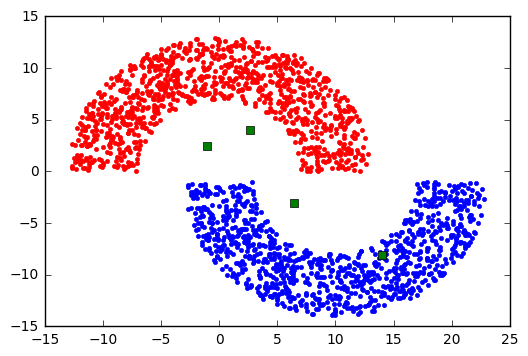

In [112]:
plot(data, target, mu)